# ПРОЕКТ "ПРОГНОЗ ИНФЛЯЦИИ"

В рамках проекта перед нами поставлена задача разработать программное решение, которое будет автоматически скачивать или загружать с помощью пользователя данные по индексам потребительских цен с официального сайта Росстата (https://rosstat.gov.ru/), анализировать полученные данные и строить модель прогноза на 6 месяцев вперед

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix

from dateutil.relativedelta import relativedelta

from datetime import datetime

import pickle

Исходные данные - значения Индекса потребительских цен на все товары и услуги (код 11521100300010200001) с 2002 г. с помесячной разбивкой. Вид показателя - к декабрю предыдущего года

## Обработка данных

In [2]:
#открываем предоставленные данные
cpi = pd.read_csv('C:\\Users\\Илья\\Documents\\Программирование\\Data Science_projects\\ИПЦ\\cpi_since_2002.csv', sep=';')

Расчет индексов цен в среднем в отчетном (например, втором) полугодии текущего года по сравнению с предыдущим полугодием текущего года проводился на месячных данных (за базу принят декабрь предыдущего года) по следующей формуле:

$CPI2hy = \dfrac{(CPIjul + CPIaug + CPIsep + CPIoct + CPInov + CPIdec) / 6}{(CPIjan + CPIfeb + CPImar + CPIapr + CPImay + CPIjun) / 6}$

In [3]:
#смотрим на представленные данные
display(cpi.head())
print()
print(cpi.shape)
print()
print(cpi.dtypes)

,date,cpi,half_year
0,01.01.2003,105.189279,2
1,01.01.2003,94.468161,1
2,01.01.2004,103.981797,2
3,01.07.2004,94.828896,1
4,01.01.2005,104.828139,2



(43, 3)

date          object
cpi          float64
half_year      int64
dtype: object


Поменяли тип данных столбца "date"

In [4]:
#меняем тип данных столбца date
cpi['date'] = pd.to_datetime(cpi['date'])
print(cpi.dtypes)

date         datetime64[ns]
cpi                 float64
half_year             int64
dtype: object


Установили столбец "date" в качестве индекса

In [5]:
#устанавливаем столбец date в качестве индекса
cpi2 = cpi.set_index('date')
display(cpi2.head())

,cpi,half_year
date,,
2003-01-01,105.189279,2
2003-01-01,94.468161,1
2004-01-01,103.981797,2
2004-01-07,94.828896,1
2005-01-01,104.828139,2


Даты расположены в хронологическом порядке

In [6]:
#в хронологическом ли порядке расположены даты и время
print(cpi2.index.is_monotonic)

True


Явная тенденция в динамике ИПЦ не прослеживается

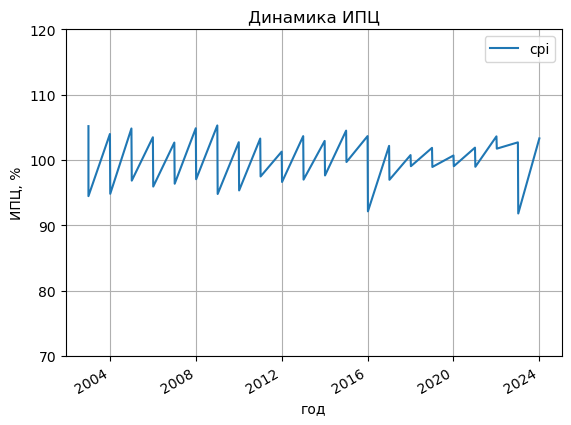

In [7]:
#график
cpi2.plot(y='cpi', xlabel = 'год', ylabel = 'ИПЦ, %', grid=True, ylim = (70, 120))
plt.title('Динамика ИПЦ');

### Дополнительные признаки

В качестве дополнительных признаков добавили лаги и скользящие средние

In [8]:
#определяем важные для анализа отстающие значения
cpi2['lag_{}'.format(1)] = cpi2['cpi'].shift(1)
cpi2['lag_{}'.format(2)] = cpi2['cpi'].shift(2)
cpi2['lag_{}'.format(4)] = cpi2['cpi'].shift(4)
display(cpi2.head())

,cpi,half_year,lag_1,lag_2,lag_4
date,,,,,
2003-01-01,105.189279,2,NaN,NaN,NaN
2003-01-01,94.468161,1,105.189279,NaN,NaN
2004-01-01,103.981797,2,94.468161,105.189279,NaN
2004-01-07,94.828896,1,103.981797,94.468161,NaN
2005-01-01,104.828139,2,94.828896,103.981797,105.189279


In [9]:
#определяем важные для анализа скользящие средние
cpi2['rolling_mean_{}'.format(2)] = cpi2['cpi'].shift().rolling(2).mean()
cpi2['rolling_mean_{}'.format(4)] = cpi2['cpi'].shift().rolling(4).mean()
display(cpi2.head())
print()
display(cpi2.tail())

,cpi,half_year,lag_1,lag_2,lag_4,rolling_mean_2,rolling_mean_4
date,,,,,,,
2003-01-01,105.189279,2,NaN,NaN,NaN,NaN,NaN
2003-01-01,94.468161,1,105.189279,NaN,NaN,NaN,NaN
2004-01-01,103.981797,2,94.468161,105.189279,NaN,99.828720,NaN
2004-01-07,94.828896,1,103.981797,94.468161,NaN,99.224979,NaN
2005-01-01,104.828139,2,94.828896,103.981797,105.189279,99.405347,99.617034


,cpi,half_year,lag_1,lag_2,lag_4,rolling_mean_2,rolling_mean_4
date,,,,,,,
2022-01-01,103.621573,2,98.961520,101.893169,100.692104,100.427344,100.149052
2022-01-07,101.739649,1,103.621573,98.961520,99.049414,101.291547,100.881419
2023-01-01,102.703745,2,101.739649,103.621573,101.893169,102.680611,101.553978
2023-01-07,91.810792,1,102.703745,101.739649,98.961520,102.221697,101.756622
2024-01-01,103.310911,2,91.810792,102.703745,103.621573,97.257269,99.968940


## Подготовка данных для работы с моделями

Разбили данные на две выборки, удалили пропуски в обучающей выборке, выделили целевой и иные признаки

In [10]:
#разбиваем данные на выборки
train, test = train_test_split(cpi2, test_size=0.2, shuffle=False)

In [11]:
#удаляем пропуски в обучающей выборке
print(train.shape)
train = train.dropna()
print(train.shape)

(34, 7)
(30, 7)


In [12]:
#выделяем целевой и иные признаки
features_train = train.drop('cpi', axis=True)
target_train = train['cpi']
    
features_test = test.drop('cpi', axis=True)
target_test = test['cpi']
      
#проверяем корректность разделения на выборки
print('features_train', features_train.index.min(), features_train.index.max())
print(features_train.shape)
print('features_test', features_test.index.min(), features_test.index.max())
print(features_test.shape)
print()
print('target_train', target_train.index.min(), target_train.index.max())
print(target_train.shape)
print('target_test', target_test.index.min(), target_test.index.max())
print(target_test.shape)

features_train 2005-01-01 00:00:00 2019-01-07 00:00:00
(30, 6)
features_test 2020-01-01 00:00:00 2024-01-01 00:00:00
(9, 6)

target_train 2005-01-01 00:00:00 2019-01-07 00:00:00
(30,)
target_test 2020-01-01 00:00:00 2024-01-01 00:00:00
(9,)


## Работа с моделями

### Случайный лес

- методом кросс-валидации выбрали параметры лучшей модели, построенной с использованием Случайного леса
- науличший результат получили при n_estimators = 10
- проверили нашу модель на тестовой выборке: значение оценочной метрики (коэффициент детерминации, R2) составило 0.52 при наилучшем качесте модели (1) и наихудшем (0)

In [13]:
#случайный лес
model_rf = RandomForestRegressor(random_state=180723)
parameters_range = {'n_estimators': [10, 51, 10]}

In [14]:
gscv_rf = GridSearchCV(model_rf, parameters_range, cv=5, scoring='r2')

In [15]:
gscv_rf.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=180723),
             param_grid={'n_estimators': [10, 51, 10]}, scoring='r2')

In [16]:
gscv_rf.best_estimator_

RandomForestRegressor(n_estimators=10, random_state=180723)

In [17]:
gscv_rf.best_score_

0.6126232678322182

### Проверка качества модели на тесте

In [18]:
prediction_test = gscv_rf.predict(features_test)
print("R2 =", r2_score(target_test, prediction_test))

R2 = 0.5227049683488152


### Сохраняем модель для дальнейшей работы с ней на веб-сайте

In [19]:
pickle.dump(gscv_rf, open('model.pkl', 'wb'))

### Прогноз нашей модели

In [20]:
#готовим df для прогноза нашей модели
cpi['lag_{}'.format(1)] = cpi['cpi'].shift(1)
cpi['lag_{}'.format(2)] = cpi['cpi'].shift(2)
cpi['lag_{}'.format(4)] = cpi['cpi'].shift(4)
cpi['rolling_mean_{}'.format(2)] = cpi['cpi'].shift().rolling(2).mean()
cpi['rolling_mean_{}'.format(4)] = cpi['cpi'].shift().rolling(4).mean()
display(cpi.head())
print()
display(cpi.tail())

,date,cpi,half_year,lag_1,lag_2,lag_4,rolling_mean_2,rolling_mean_4
0,2003-01-01,105.189279,2,NaN,NaN,NaN,NaN,NaN
1,2003-01-01,94.468161,1,105.189279,NaN,NaN,NaN,NaN
2,2004-01-01,103.981797,2,94.468161,105.189279,NaN,99.828720,NaN
3,2004-01-07,94.828896,1,103.981797,94.468161,NaN,99.224979,NaN
4,2005-01-01,104.828139,2,94.828896,103.981797,105.189279,99.405347,99.617034


,date,cpi,half_year,lag_1,lag_2,lag_4,rolling_mean_2,rolling_mean_4
38,2022-01-01,103.621573,2,98.961520,101.893169,100.692104,100.427344,100.149052
39,2022-01-07,101.739649,1,103.621573,98.961520,99.049414,101.291547,100.881419
40,2023-01-01,102.703745,2,101.739649,103.621573,101.893169,102.680611,101.553978
41,2023-01-07,91.810792,1,102.703745,101.739649,98.961520,102.221697,101.756622
42,2024-01-01,103.310911,2,91.810792,102.703745,103.621573,97.257269,99.968940


In [21]:
df_col = ['half_year', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_2', 'rolling_mean_4']
df_date = [[1.0, cpi.loc[cpi.shape[0]-1, 'cpi'], cpi.loc[cpi.shape[0]-2, 'cpi'], cpi.loc[cpi.shape[0]-4, 'cpi'], \
            (cpi.loc[cpi.shape[0]-1, 'cpi'] + cpi.loc[cpi.shape[0]-2, 'cpi']) / 2, \
            (cpi.loc[cpi.shape[0]-1, 'cpi'] + cpi.loc[cpi.shape[0]-2, 'cpi'] + \
             cpi.loc[cpi.shape[0]-3, 'cpi'] + cpi.loc[cpi.shape[0]-4, 'cpi']) / 4]]
features_20240701 = pd.DataFrame(columns = df_col, data = df_date)
display(features_20240701)

,half_year,lag_1,lag_2,lag_4,rolling_mean_2,rolling_mean_4
0,1.0,103.310911,91.810792,101.739649,97.560852,99.891274


In [22]:
#делаем предсказание модели
forecast = gscv_rf.predict(features_20240701)
print(forecast)

[98.08203305]


In [23]:
#строим df для посроения графика с учетом прогноза
cpi3 = cpi.drop(['half_year', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_2', 'rolling_mean_4'], axis=True)
display(cpi3.head())

,date,cpi
0,2003-01-01,105.189279
1,2003-01-01,94.468161
2,2004-01-01,103.981797
3,2004-01-07,94.828896
4,2005-01-01,104.828139


In [24]:
df_col = ['date', 'cpi']
df_data = [[cpi.loc[cpi.shape[0]-1, 'date'] + relativedelta(months=6), forecast[0]]]
df_forecast = pd.DataFrame(columns=df_col, data = df_data)
display(df_forecast.head())
print(df_forecast.dtypes)

,date,cpi
0,2024-07-01,98.082033


date    datetime64[ns]
cpi            float64
dtype: object


In [25]:
cpi3_final = pd.concat([cpi3, df_forecast]).reset_index(drop=True)
display(cpi3_final.tail())

,date,cpi
39,2022-01-07,101.739649
40,2023-01-01,102.703745
41,2023-01-07,91.810792
42,2024-01-01,103.310911
43,2024-07-01,98.082033


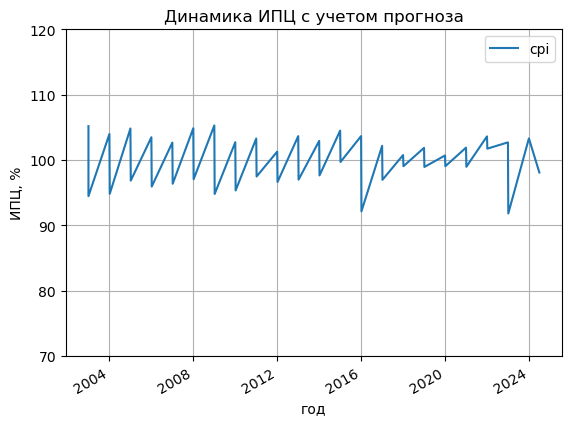

In [26]:
#строим график
cpi3_final.plot(x='date', y='cpi', xlabel = 'год', ylabel = 'ИПЦ, %', grid=True, ylim = (70, 120))
plt.title('Динамика ИПЦ с учетом прогноза');

## Вывод по проекту

- В рамках проекта удалось построить модель машинного обучения, которая прогнозирует индекс ИПЦ на 6 месяцев вперед. 
- На тестовой выборке значение оценочной метрики (коэффициент детерминации, R2) нашей модели составило 0.52 при наилучшем качесте модели (1) и наихудшем (0).
- Модель была сохранена и использована в дальнейшем для работы с ней на веб-сайте